# Image Resampling Detection

### Import

In [1]:
%matplotlib inline
import os
import numpy as np
import cv2
from scipy.signal import medfilt2d
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage.interpolation import geometric_transform
import matplotlib.pylab as plt

### Generate Edited Image

In [2]:
# Parameters
image_in_path = 'uncompressed.tif'
res_factor = 1.5

In [3]:
# Resize image
img_in = cv2.imread(image_in_path, cv2.IMREAD_COLOR)
img_res = cv2.resize(img_in, (np.int(res_factor*img_in.shape[1]),
                              np.int(res_factor*img_in.shape[0])))

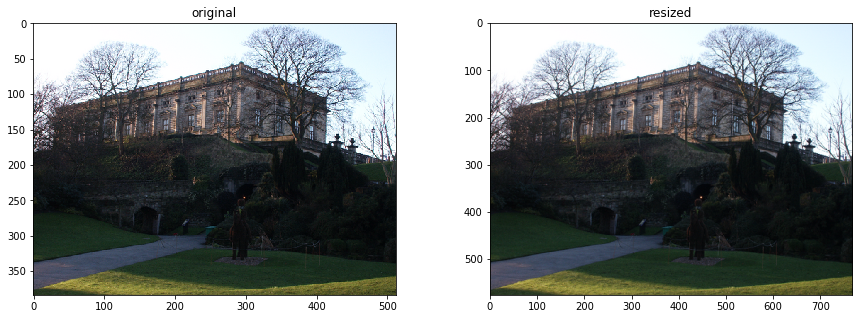

In [4]:
# Display
plt.figure(figsize=(15, 5))
plt.subplot(121), plt.imshow(img_in[:, :, [2,1,0]]) # dirty BGR to RGB conversion
plt.title('original')
plt.subplot(122), plt.imshow(img_res[:, :, [2,1,0]])
plt.title('resized')
plt.show()

### Fast Detector
- M. Kirchner, "[Fast and reliable resampling detection by spectral analysis of fixed linear predictor residue](https://dl.acm.org/citation.cfm?id=1411333)", ACM Workshop on Multimedia and Security (MM&Sec), 2008

In [5]:
# Input
img = cv2.cvtColor(img_res, cv2.COLOR_BGR2GRAY).astype(np.float32)

In [6]:
# Parameters
block = 256     # cropped block size
lam = 1         # contrast parameter
sig = 1         # contrast parameter
tau = 2         # contrast parameter
dc_margin = 10  # zero-region around DC

# low-pass filter
alpha = np.array([(-0.25, 0.50, -0.25),
                  ( 0.50, 0,     0.50),
                  (-0.25, 0.50, -0.25)])

# FFT contrast function
def contrast(x):
    return cv2.GaussianBlur(x, (3, 3), 0)**3

In [7]:
# Crop
img = img[0:block, 0:block]

In [8]:
# P-map computation
e = img - cv2.filter2D(img, -1, alpha, cv2.BORDER_REFLECT)
p = lam * np.exp(-(np.abs(e)**tau) / sig)

In [9]:
# Contrasted spectrum
P = contrast(np.abs(np.fft.fft2(p)))

In [10]:
# Cumulative periodogram
P = P[:np.int(block/2), :np.int(block/2)]
num = np.cumsum(np.cumsum(np.abs(P)**2, axis=1), axis=0)
den = np.sum(np.abs(P)**2)
C = num / den

In [11]:
# Remove DC peaks
C = C[dc_margin:, dc_margin:]

In [12]:
# Detect
sobelx = cv2.Sobel(C, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(C, cv2.CV_64F, 0, 1, ksize=5)
delta = np.max((np.abs(sobelx), np.abs(sobely)))

Confidence: 6.008148193359375e-05


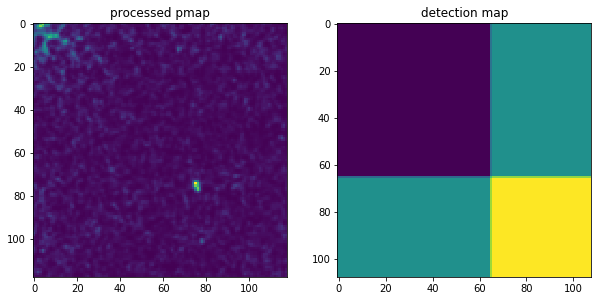

In [13]:
# Display
print('Confidence: {}'.format(delta))
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(P[dc_margin: , dc_margin:]), plt.title('processed pmap')
plt.subplot(122), plt.imshow(C[dc_margin: , dc_margin:]), plt.title('detection map')
plt.show()

### JPEG-aware Detector
- M. Kirchner, T. Gloe, "[On resampling detection in re-compressed images](http://ws.binghamton.edu/kirchner/papers/2009_WIFS.pdf)", IEEE International Workshop on Information Forensics and Security (WIFS), 2009

In [14]:
# Input
img = cv2.cvtColor(img_res, cv2.COLOR_BGR2GRAY).astype(np.float32)

In [15]:
# Parameters
block = 512     # cropped block size
W = 4           # maximum-filter window size
gamma = 4       # contrast enhancement
dc_margin = 10  # zero-region around DC

# low-pass filter
alpha4 = np.array([(    0, 0.25,     0),
                   ( 0.25, 0,     0.25),
                   (    0, 0.25,     0)])
alpha8 = np.array([(-0.25, 0.50, -0.25),
                   ( 0.50, 0,     0.50),
                   (-0.25, 0.50, -0.25)])

# FFT contrast function
def contrast(x):
    return cv2.GaussianBlur(x, (3, 3), 0)**3

In [16]:
# Crop
img = img[0:block, 0:block]

In [17]:
# P-map computation
e = img - cv2.filter2D(img, -1, alpha4, cv2.BORDER_REFLECT)
p = np.exp(-(np.abs(e)**2))

In [18]:
# Spectrum
P = np.abs(np.fft.fft2(p))

In [19]:
# Spectrum folding (custom)
P = P[:np.int(block/2), :np.int(block/2)] + \
    np.fliplr(P[:np.int(block/2), -np.int(block/2):]) + \
    np.flipud(P[-np.int(block/2):, :np.int(block/2)]) + \
    np.flipud(np.fliplr(P[-np.int(block/2):, -np.int(block/2):]))

In [20]:
# Spectrum normalization
P_median = medfilt2d(P, (7, 7))
P_n = P / (P_median + 1e-10)
P_n[np.where(P_median == 0)] = 0

In [21]:
# Maximum filter
P_m_aux = maximum_filter(P_n, (W, W))
P_m = np.zeros(P_m_aux.shape)
P_m[np.where(P_n == P_m_aux)] = P_n[np.where(P_n == P_m_aux)]

In [22]:
# Emphasize strong peaks
P_gamma = np.max(P_m) * (P_m / np.max(P_m))**gamma

In [23]:
# Cartesian to polar transformation
def topolar(img, order=1):
    """
    Transform img to its polar coordinate representation.

    order: int, default 1
        Specify the spline interpolation order. 
        High orders may be slow for large images.
    """
    # max_radius is the length of the diagonal 
    # from a corner to the mid-point of img.
    max_radius = 0.5*np.linalg.norm(img.shape)

    def transform(coords):
        # Put coord[1] in the interval, [-pi, pi]
        theta = 2*np.pi*coords[1] / (img.shape[1] - 1.)

        # Then map it to the interval [0, max_radius].
        #radius = float(img.shape[0]-coords[0]) / img.shape[0] * max_radius
        radius = max_radius * coords[0] / img.shape[0]

        i = 0.5*img.shape[0] - radius*np.sin(theta)
        j = radius*np.cos(theta) + 0.5*img.shape[1]
        return i,j

    polar = geometric_transform(img, transform, order=order)

    rads = max_radius * np.linspace(0,1,img.shape[0])
    angs = np.linspace(0, 2*np.pi, img.shape[1])

    return polar, (rads, angs)

In [24]:
# Detect
P_pol, (_, _) = topolar(np.fft.fftshift(P_gamma))
pol_sum = np.sum(P_pol, axis=1)
delta = np.max(pol_sum) / np.median(pol_sum)

Confidence: 843.0206391677663


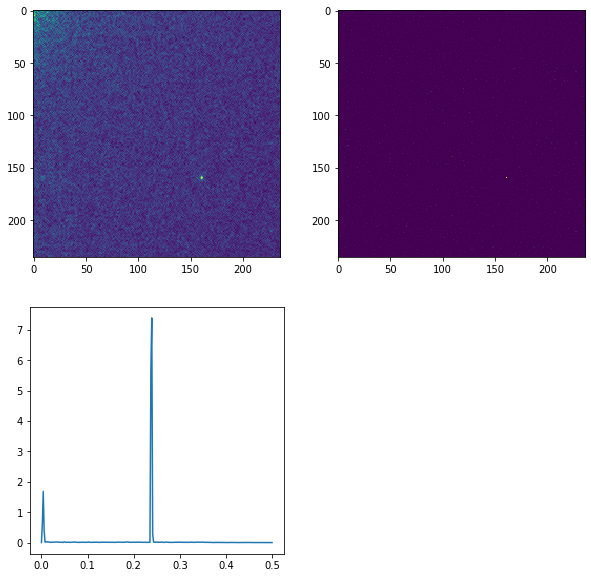

In [25]:
# Display
print('Confidence: {}'.format(delta))
plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(P[dc_margin:-dc_margin, dc_margin:-dc_margin])
plt.subplot(222), plt.imshow(P_gamma[dc_margin:-dc_margin, dc_margin:-dc_margin])
plt.subplot(223), plt.plot(np.linspace(0, 0.5, len(pol_sum)), pol_sum[0:])
plt.show()